# Assignment 

In this assignment, we will design a regression model by using the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. 

We will familiarize ourselves with the data by performing EDA to identify trends, spot anaomiles, select features, and more. Once this stage is complete, we will build a regression model to predict house prices. 


In [2]:
# Libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA 
from sklearn import linear_model
from sqlalchemy import create_engine
import warnings


# Import data

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning and Formatting 

### Load in the Data  and Examine

First, we will create a copy of the original house price dataframe so that we can manipulate and clean the data without disturbing the original dataset. We will begin by loading the data and format the column names by stripping spaces and convert to lowercase. 

In [3]:
# Rename columns that contain trailing spaces

df = houseprices_df.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

print(df.shape)

df.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
# Datatypes 

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

There are 81 attributes and 1,460 rows in this dataset. Currently, there are 43 categorical and 38 continous varibles describing aspects of houses sold in Ames, Iowa. There are a couple of date columns were entered as integers. Next, we will convert the columns to strings. 

In [5]:
# Convert to string 

convert_date = ['yearbuilt','yearremodadd','mosold','yrsold']

df[convert_date] = df[convert_date].astype(str)

In [6]:
num_var = df.select_dtypes(['int64', 'float64']).columns
print('There are {} numeric varibles'.format(len(num_var)))

cat_var = df.select_dtypes(['object']).columns
print('There are {} categorical varibles'.format(len(cat_var)))

There are 34 numeric varibles
There are 47 categorical varibles


After converting data to the correct types, we now have 34 numeric and 47 categorical variables. 

Let's get a basic description of the dataset by viewing summary statistics.

In [7]:
# Dataframe statistics 

df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,181.066207,456.098091,161.319273,441.866955,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,166.000000,712.250000,0.000000,808.000000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


In [8]:
df.describe(include=['object'])

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,mosold,yrsold,saletype,salecondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1460,7,281,54,1460,1460,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,5,5,3,3,4,4,12,5,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,TA,TA,Y,Gd,MnPrv,Shed,6,2009,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,1311,1326,1340,3,157,49,253,338,1267,1198


Here are some initial observations:
 - Lot area varies drastically from 1,300 square feet (2 bedroom) to 215,245 square feet (mega-mansion).
 - The average house has a basement of 1,057 square feet. 
 - Majority of garages can store up to 2 cars.
 - The average pool area is around 2 square feet, which indicates that these houses probably do not have a pool. This may be typical of a house in Iowa. 
 - The sale prices ranges from \$34,900 to \$755,000. The average price for a house was around \$180,921. 
  
 - These houses were built from 1872 to 2010. The average house in this dataset was built around 1971.
 - Houses in Northern Ames neighborhood were sold the most. 
 - The data captures houses sold from 2006 to 2010. Summer months, particularly June 2009 was the most popular buying season.


### Missing Values 

After correcting column datatypes, we will start Exploratory Data Analysis will looking at the percentage of missing datapoints in each column. 

In [9]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
missing_values_table(df)

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
poolqc,1453,99.5
miscfeature,1406,96.3
alley,1369,93.8
fence,1179,80.8
fireplacequ,690,47.3
lotfrontage,259,17.7
garagetype,81,5.5
garageyrblt,81,5.5
garagefinish,81,5.5
garagequal,81,5.5


We can observe that the top 5 variables in the table are missing more than 40% of datapoints. Since these features don't appear to be the top qualities of what people may prioritize when purchasing a house, we will delete these columns. 

Since the remaining columns are both numeric and categorical, we can impute missing values with their respective mode. 


In [11]:
# Get the columns with >= 40% missing

missing_df = missing_values_table(df)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 40].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.
We will remove 5 columns.


In [12]:
# Drop the columns

df = df.drop(columns = list(missing_columns))

Now we will fill in missing values with the mean. 

In [16]:
# Imputation by mode

df = df.fillna(df.mode().iloc[0])

Let's check to see whether the null values were missing at random by comparing descriptive statistics before and after dropping the values. 

In [17]:
# Check to see remaining null values 

missing_values_table(df)

Your selected dataframe has 76 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [18]:
# Dataset before drop values 

houseprices_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [19]:
# Dataset after drop values 
df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,421.610009,42.300571,22.024023,9981.264932,1.382997,1.112799,180.569112,456.098091,161.319273,441.866955,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,730.500000,50.000000,70.049958,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


There doesn't appear to be a drastic change in the means after dropping the null values so we will assume that the data was completely missing at random. 
  

## Exploring Data 

Now that we have "cleaned" the data, we can begin exploratory data analysis. The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process. 


### Univariate Analysis 

We will begin EDA by exploring individual variables, particularly sale price since it is our target variable. 

Text(0.5, 1.0, 'Sale Price')

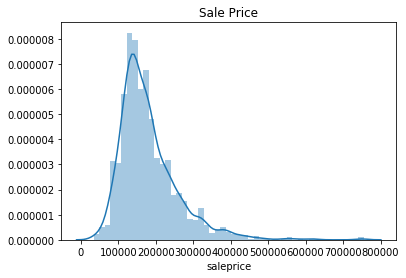

In [20]:
# Plot sale price 

sns.distplot(df.saleprice)
plt.title('Sale Price')

We can observe that the distribution of sale price is heavely skewed to the right. Let's look at some statistics for this feature. 

In [27]:
df['saleprice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

We can see that there is a large price gap between 75% of house prices being listed under $214,000 and the maximum value of $755,000.



In [28]:
df.loc[df['saleprice']>=700000]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,555,0,7,2007,WD,Abnorml,745000


Let's continue to plot common factors a buyer might focus on when purchasing a house, such as the house style, utilies type, garage space, and overall quality finish of the house. 

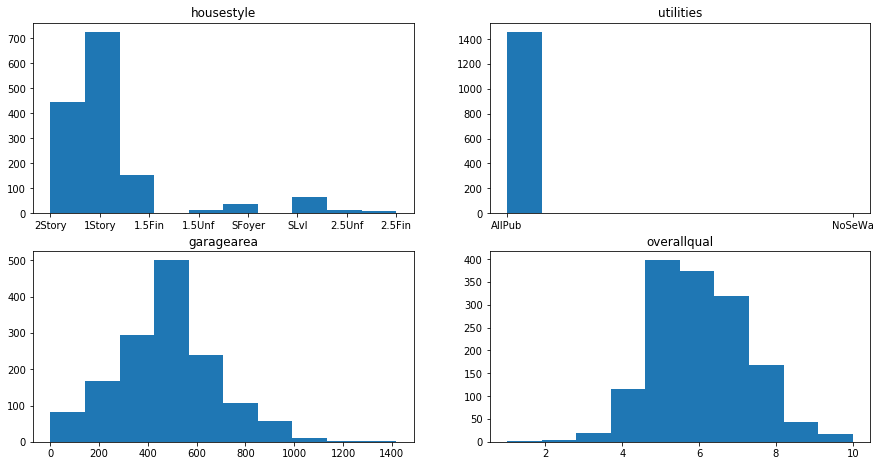

In [26]:
# Plot variables 

col = ['housestyle','utilities','garagearea','overallqual']

plt.figure(figsize=(15,75))

for i in range(len(col)):
    plt.subplot(18,2,i+1)
    plt.hist(df[col[i]])
    plt.title(col[i])

plt.show()

We can see that all variables are not normally distributed. In the first graph, most data points are concentrated around 1 and 2 story houses, which is typical of house styles. There are a couple of values that fall in the 2.5 unfinished and finished bins, possibly pulling the distribution to the right. Utilities appears to be a binary variable with all data points in the all public utilities (electric, gas, water,& septic) bin. While garage area is positively skewed, the overall qualities of the houses show skewing towards the left.

These outliers can throw a model since it causes the distribution to skew. We will deal with extreme values before modeling. 

### Removing Outliers

Although outliers contain meaningful information, linear regression machine learning models are sensitive to extreme values so we will exclude some extreme values. We will set the threshold at 3 standard deviations as it will allow us to retain 99% of the dataset. Then, we will replace the them with the median value since it is not effected by outliers. 

In [ ]:
# Correlation between sale price and numeric variables 

corrmat = df.corr()
print(corrmat['saleprice'].sort_values(ascending = False),'\n')

The most correlated variables to sale price:
 - overallqual: overall material and finish quality
 - grlivarea: above grade (ground) living area square feet
 - garagecars: size of garage in car capacity
 - garagearea: size of garage in square feet
 - totalbsmtsf: total square feet of basement area
 - firstflrsf: first floor square feet

These results make sense since buyers would be interested in knowing the general living space, quality of the house, and garage capacity.  

With the variables identified above, we will continue to explore their relationship with sale price through scatter plots. 

In [ ]:
top_var = df.loc[:,['overallqual','grlivarea','garagecars',
                    'garagearea','totalbsmtsf','firstflrsf','saleprice']]
sns.pairplot(top_var, y_vars="saleprice", x_vars=top_var.columns.values)

We can observe that most of the variables have somewhat of a linear relationship with sale price. The scatter plot also offers insight in possible outliers. We can see outliers on the far right for ground living area, garage area, total basement area, first floor, and sale price. 



In [ ]:
# Create function to detect outliers by using standard deviation 

def out_std(s):
    # calculate summary statistics
    data_mean, data_std = s.mean(), s.std()
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in s if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    print(outliers)
    outliers_removed = [x for x in s if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))


In [ ]:
# Outlier values 

out_std(df['overallqual'])
out_std(df['grlivarea'])
out_std(df['garagecars'])
out_std(df['garagearea'])
out_std(df['totalbsmtsf'])
out_std(df['firstflrsf'])

In [ ]:
#Features with Outliers 

numcol=['overallqual', 'grlivarea',
       'garagearea', 'totalbsmtsf', 'firstflrsf']
for column in numcol:
    if df[column].quantile(.9973)<df[column].max():
        print(column)
        print('99th Percentile',df[column].quantile(.9973))
        print('Max',df[column].max())
        print('Outliers Present in Column {}'.format(column))
        print('')
    elif df[column].quantile(0)>df[column].min():
        print(column)
        print('99th Percentile',df[column].quantile(.9973))
        print('Min',df[column].min())
        print('Outliers Present in Column {}'.format(column))
        print('')
    else:
        pass

NOTE: I have not figured out a way to automatically remove outliers and save it in a new dataset. 

In [ ]:
# Replacing outliers with median values 

median = df['overallqual'].median()
df["overallqual"] = np.where(df["overallqual"] == 1, median,df['overallqual'])    

median = df['grlivarea'].median()
df["grlivarea"] = np.where(df["grlivarea"] >= 3112, median,df['grlivarea'])

median = df['garagearea'].median()
df["garagearea"] = np.where(df["garagearea"] >= 1134, median,df['garagearea'])  

median = df['totalbsmtsf'].median()
df["totalbsmtsf"] = np.where(df["totalbsmtsf"] >= 2392, median,df['totalbsmtsf'])  

median = df['firstflrsf'].median()
df["firstflrsf"] = np.where(df["firstflrsf"] >= 2392, median,df['firstflrsf'])  

## Feature Engineering
In this step, we will select features for our linear regression model. First, let's start with the numeric values. Previously, we identified 6 numeric variables that are highly correlated to sale price. We will use a heat map to check if the variables on highly correlated to each other before continuing. 

In [ ]:
# Heatmap of most correlated variables 

corrmat = top_var.corr()
sns.heatmap(corrmat)

The variables look relatively independent of each other. Let's try running our first linear regression model with only numeric variables. 

### Iteration 1

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes
X = df[['overallqual','grlivarea','garagearea','totalbsmtsf','firstflrsf']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

LinearRegression fit method runs the OLS algorithm by default. Since we get the parameters using OLS, we can write our estimated model:

$$ saleprice = -121239.52 + 27,285.82\_overallqual + 37.28\_grlivarea + 62.96\_garagearea + 27.38\_totalbsmtsf + 19.03\_firstflrsf

In [ ]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

NOTE: I am not sure of how I am suppose to interpet the results. 

## Iteration 2 

The variables look relatively independent of each other. Let's continue to explore the categorical variables. We will need to convert strings to numerical values. We will use __one hot encoding__ to separate variables into numbers for each unique value. 

In [ ]:
# Create dataframe of categorical variables 

cat_var_dum = pd.get_dummies(cols = cat_var.columns, drop_first=True)
cat_var_dum.head()